In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def initial_spins(N, temperature):
    spin_0 = np.random.choice([1,-1])
    if temperature <= 2.2:
        lattice = np.random.choice([spin_0, -spin_0], size=(N,N), p=[0.9, 0.1])
    if temperature > 2.2 and temperature <= 2.4:
        lattice = np.random.choice([spin_0, -spin_0], size=(N,N), p=[0.7, 0.3])
    if temperature > 2.4:
        lattice = np.random.choice([spin_0, -spin_0], size=(N,N), p=[0.5, 0.5])
    return lattice


def system_energy(lattice, J, magn_field):
#     this method is way faster the the double for loop

    energy = -J * np.sum(lattice * (np.roll(lattice, -1, axis=0) + np.roll(lattice, -1, axis=1))) - magn_field * np.sum(lattice)
    return energy

def possible_energy(temperature, magn_field):
    first_poss = np.exp(-(2*abs(magn_field))/(temperature))
    second_poss = np.exp(-(4.0 + 2*abs(magn_field))/(temperature))
    third_poss = np.exp(-(4.0 - 2*abs(magn_field))/(temperature))
    fourth_poss = np.exp(-(8.0 + 2*abs(magn_field))/(temperature))
    fifth_poss = np.exp(-(8.0 - 2*abs(magn_field))/(temperature))
    return first_poss, second_poss, third_poss, fourth_poss, fifth_poss

def monte_carlo(lattice, coupling_constant, temperature, magn_field, first_poss, second_poss, third_poss, fourth_poss, fifth_poss):
    beta = 1/temperature
    size = len(lattice[0,:])
    random_x, random_y = np.random.randint(size, size=2)
    delta_E = 2 * coupling_constant * lattice[random_x, random_y] * (lattice[(random_x-1)%size, random_y] 
                                                              + lattice[(random_x+1)%size, random_y] 
                                                              + lattice[random_x, (random_y-1)%size] 
                                                              + lattice[random_x, (random_y+1)%size]) + magn_field * lattice[random_x, random_y]
    if delta_E <= 0:
        lattice[random_x, random_y] *= -1
        return lattice, delta_E
    if delta_E == 2*abs(magn_field):
        if np.random.rand() <= first_poss:
            lattice[random_x, random_y] *= -1
            return lattice, delta_E
    if delta_E == 4 - 2*abs(magn_field):
        if np.random.rand() <= second_poss:
            lattice[random_x, random_y] *= -1
            return lattice, delta_E
    if delta_E == 4 + 2*abs(magn_field):
        if np.random.rand() <= third_poss:
            lattice[random_x, random_y] *= -1
            return lattice, delta_E
    if delta_E == 8 - 2*abs(magn_field):
        if np.random.rand() <= fourth_poss:
            lattice[random_x, random_y] *= -1
            return lattice, delta_E
    if delta_E == 8 + 2*abs(magn_field):
        if np.random.rand() <= fifth_poss:
            lattice[random_x, random_y] *= -1
            return lattice, delta_E
    
    return lattice, 0





def show_snapshot(lattice, timestep):
    
    plt.imshow(lattice, cmap='binary')
    plt.title(f'Timestep {timestep}')
    plt.show()


def ising_simulation(size, coupling_constant, temperature, timesteps, magn_field):

    lattice = initial_spins(size, temperature)
    energies = np.zeros((timesteps))
    magnetizations =  np.zeros((timesteps))
    first_poss, second_poss, third_poss, fourth_poss, fifth_poss = possible_energy(temperature, magn_field) 
    if temperature >= 1.8 and temperature <= 2.6:
        t_to_eq = 300000
    else:
        t_to_eq = 30000
    for i in range(timesteps + t_to_eq):
        lattice, delta_E = monte_carlo(lattice, coupling_constant, temperature, magn_field, first_poss, second_poss, third_poss, fourth_poss, fifth_poss) 
        if i >= t_to_eq:
            energies[i- t_to_eq] = (system_energy(lattice, coupling_constant, magn_field)/size**2)
            magnetizations[i - t_to_eq] = (np.sum(lattice)/size**2)
            
#             if i%10000 == 0:
#                 show_snapshot(lattice, i-t_to_eq)
                
    return (energies), (magnetizations)

def auto_correlation(magnetization, timestep):
    xi = np.zeros(timestep)
    for t in range(timestep):
        xi[t] = (np.sum(magnetization[0:timestep-t]*magnetization[t:timestep])) * (timestep-t)**(-1) -  ((np.sum(magnetization[0:timestep-t]) * (timestep-t)**(-1) ) * (np.sum(magnetization[t:timestep]) * (timestep-t)**(-1)))
        
    return xi

def corr_time(chi):
    i = 0
    integral = 0
    while chi[i] >= 0:
        integral += chi[i]/chi[0]
        i += 1
    return integral


def average_chi(size, coupling_constant, temperature, timesteps, magn_field): #test
    iterations = 10
    average_chi = np.zeros((timesteps))
    tau_noised = np.zeros((iterations))
    for i in range(iterations):
        energies, magnetizations = ising_simulation(size, coupling_constant, temperature, timesteps, magn_field)
        chi_noised = auto_correlation(magnetizations, timesteps)
        tau_noised[i] = corr_time(chi_noised)
        average_chi += chi_noised
        print('iteration ' , i)
    return average_chi/iterations, tau_noised

def average_tau(size, coupling_constant, temperature, timesteps, magn_field):
    time_correlation, tau_noise = average_chi(size, coupling_constant, temperature, timesteps, magn_field)
    average_tau = corr_time(time_correlation)
    std_tau = np.std(tau_noise)
    return average_tau, std_tau



def magnetic_susceptibility(magnetization, tau, temperature, n_spins, t_max):
    """Computes the magnetic susceptibility per spin for equal blocks of size 16*tau"""
    #block_length = 16*tau
    block_length = int(16*tau)
    beta = 1/temperature
    magn_susc = []    
    for j in np.arange(0, int(t_max/block_length)):
        magn_susc.append((beta/n_spins**2)*(np.mean(magnetization[j*block_length:(j+1)*block_length]**2)-np.mean(magnetization[j*block_length:(j+1)*block_length])**2))
    mean_magn_susc = np.mean(magn_susc)
#     stdev_susceptibility = np.sqrt((2*tau/t_max)*(np.mean(magn_susc**2)-np.mean(magn_susc)**2))
    stdev_susceptibility = np.std(magn_susc)
    return mean_magn_susc, stdev_susceptibility

def specific_heat(energy, tau, temperature, n_spins, t_max):
    """Computes the specific heat per spin for equal blocks of size 16*tau"""
    block_length = int(16*tau)
    k_B = 1
    spec_heat = []
    for h in np.arange(0, int(t_max/block_length)):
        spec_heat.append((1/(k_B*temperature**2*n_spins**2))*(np.mean(energy[h*block_length:(h+1)*block_length]**2)-np.mean(energy[h*block_length:(h+1)*block_length])**2))
    mean_spec_heat = np.mean(spec_heat)
#     stdev_specific_heat = np.sqrt((2*tau/t_max)*(np.mean(spec_heat**2)-np.mean(spec_heat)**2))
    stdev_specific_heat = np.std(spec_heat)
    return mean_spec_heat, stdev_specific_heat

def avg_magnetization_and_stdev(magnetization, tau, t_max):
    #t_max = sweeps
    mean_magnetization = np.mean(np.abs(magnetization)) 
    stdev_magnetization = np.sqrt((2*tau/t_max)*(np.mean(magnetization**2)-np.mean(magnetization)**2))
    return mean_magnetization, stdev_magnetization
                                  
def avg_energy_and_stdev(energy, tau, t_max):
    mean_energy = np.mean(energy)
    stdev_energy = np.sqrt((2*tau/t_max)*(np.mean(energy**2)-np.mean(energy)**2))
    return mean_energy, stdev_energy
                           


def run_simulation():
    n_spins = 50
    coupling_constant = 1
    n_steps = 100000
    temperature = np.arange(1.0, 4.1, 0.2)
    magn_field = 0
    
    energies = np.zeros(len(temperature))
    energies_error = np.zeros(len(temperature))
    magnetizations = np.zeros(len(temperature))
    magnetizations_error = np.zeros(len(temperature))
    spec_heat = np.zeros(len(temperature))
    spec_heat_error = np.zeros(len(temperature))
    magnetic_susc = np.zeros(len(temperature))
    magnetic_susc_error = np.zeros(len(temperature))
    correlation_time = np.zeros(len(temperature))
    correlation_time_error = np.zeros(len(temperature))
    
    for i in range(len(temperature)):
        correlation_time[i], correlation_time_error[i] = average_tau(n_spins, coupling_constant, temperature[i], n_steps, magn_field)
        print('hello')
        t_max = int(10*16*correlation_time[i])
        energy, magnetiz = ising_simulation(n_spins, coupling_constant, temperature[i], t_max, magn_field)
        print('hello2')
        spec_heat[i], spec_heat_error[i] = specific_heat(energy, correlation_time[i], temperature[i], n_spins, t_max)
        magnetic_susc[i], magnetic_susc_error[i] = magnetic_susceptibility(magnetiz, correlation_time[i], temperature[i], n_spins, t_max)
        energies[i], energies_error[i] = avg_energy_and_stdev(energy, correlation_time[i], t_max)
        magnetizations[i], magnetizations_error[i] = avg_magnetization_and_stdev(magnetiz, correlation_time[i], t_max)
        print(i)
    return energies, energies_error, magnetizations, magnetizations_error, spec_heat, spec_heat_error, magnetic_susc, magnetic_susc_error, correlation_time, correlation_time_error


def plot_corr_time(temperature, tau, tau_error):
    plt.figure()
    plt.errorbar(temperature, tau/2500, yerr = tau_error/2500, fmt='x:b')
    plt.xlabel('Temperature')
    plt.ylabel(r'$\tau$')
    plt.title('Auto-correlation time for H = 3')
    plt.savefig('corr_timeH3.png')
    plt.show()


def plot_specific_heat(temperature, spec_heat, spec_heat_err):
    plt.figure()
    plt.errorbar(temperature, spec_heat, spec_heat_err, fmt='x:r')
    plt.xlabel('Temperature')
    plt.ylabel(r'$C$')
    plt.title('Specific heat for H = 3')
    plt.savefig('sp_heatH3.png')
    plt.show()
    
def plot_magnetic_susc(temperature, magn_susc, magn_susc_err):
    plt.figure()
    plt.errorbar(temperature, magn_susc, magn_susc_err, fmt='x:g')
    plt.xlabel('Temperature')
    plt.ylabel(r'$\chi_M$')
    plt.title('Magnetic susceptibility for H = 3')
    plt.savefig('magn_suscH3.png')
    plt.show()
    
def plot_average_spin(temperature, magnetization, magnetization_err):
    plt.figure()
    plt.errorbar(temperature, magnetization, magnetization_err, fmt='x:c')
    plt.xlabel('Temperature')
    plt.ylabel(r'$m$')
    plt.title('Mean absolute spin for H = 3')
    plt.savefig('magnetizationH3.png')
    plt.show()
    
def plot_energy(temperature, energy, energy_err):
    plt.figure()
    plt.errorbar(temperature, energy, energy_err, fmt='x:m')
    plt.xlabel('Temperature')
    plt.ylabel(r'$e$')
    plt.title('Energy per spin for H = 3')
    plt.savefig('energyH3.png')
    plt.show()

In [3]:
n_spins = 50
coupling_constant = 1
n_steps = 100000
temperature = 1.4
magn_field = 3

energies, energies_error, magnetizations, magnetizations_error, spec_heat, spec_heat_error, magnetic_susc, magnetic_susc_error, correlation_time, correlation_time_error = run_simulation()

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
hello
hello2
0
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
hello
hello2
1
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
hello
hello2
2
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
hello
hello2
3
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
hello
hello2
4
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
hello
hello2
5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9


In [4]:
temperature = np.arange(1, 4.1, 0.2)

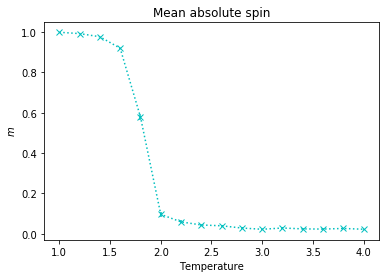

In [5]:
plot_average_spin(temperature, magnetizations, magnetizations_error)

In [6]:
print(magnetizations)
print(magnetizations_error)

[0.99859702 0.9920415  0.9764251  0.91942662 0.57909647 0.0967534
 0.05928672 0.04403389 0.0399545  0.02880714 0.022792   0.02901346
 0.02462141 0.02376661 0.02670988 0.02289034]
[0.00013235 0.00032784 0.00070507 0.0019904  0.01280093 0.01306101
 0.00793501 0.00571515 0.00578611 0.00415178 0.00324871 0.00390052
 0.00349259 0.00328001 0.00349428 0.00314985]


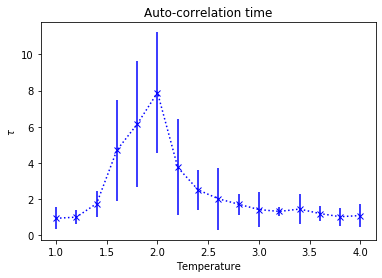

In [7]:
plot_corr_time(temperature, correlation_time, correlation_time_error)

In [8]:
print(correlation_time)
print(correlation_time_error)

[ 2365.10140394  2529.8717649   4396.26752786 11781.64047695
 15369.03419717 19725.33911132  9388.13759428  6295.25132983
  5059.67100504  4309.50271591  3570.68819086  3314.04528144
  3640.90047577  3024.42544605  2589.00307238  2747.39501937]
[1537.67859854 1000.70387526 1795.31062198 6962.63303814 8664.98533052
 8328.73107034 6630.58637737 2742.12634238 4296.52127111 1422.6201545
 2425.8681455   564.62362977 2057.66150478  996.38858597 1268.29148895
 1619.00446429]


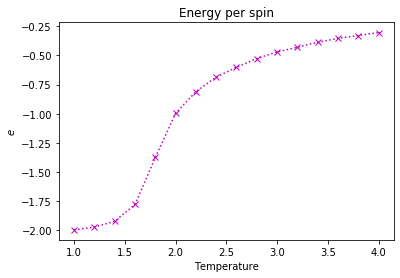

In [9]:
plot_energy(temperature, energies, energies_error)

In [10]:
print(energies)
print(energies_error)

[-1.99457128 -1.97097834 -1.92060118 -1.77715224 -1.37478287 -0.99595351
 -0.81162326 -0.68582237 -0.60223154 -0.52764724 -0.47063831 -0.4309986
 -0.38825457 -0.35481044 -0.33089978 -0.30578889]
[0.00050639 0.00112248 0.00200558 0.00372964 0.0070897  0.00488182
 0.0042001  0.00411705 0.00397911 0.00358588 0.0036803  0.00363586
 0.00348422 0.00333105 0.00336725 0.00329079]


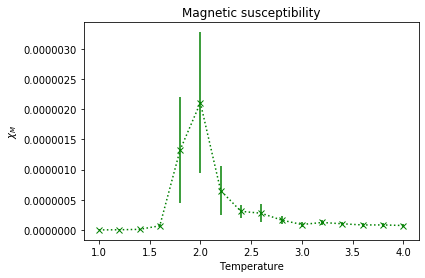

In [11]:
plot_magnetic_susc(temperature, magnetic_susc, magnetic_susc_error)

In [12]:
print(magnetic_susc)
print(magnetic_susc_error)

[5.14005181e-10 2.47745051e-09 9.73240600e-09 6.83609472e-08
 1.32376624e-06 2.10700399e-06 6.52715390e-07 3.07854455e-07
 2.76508460e-07 1.63452480e-07 8.98356059e-08 1.23257836e-07
 1.01834589e-07 8.23703458e-08 8.27860755e-08 7.31515923e-08]
[2.91152847e-10 7.49398584e-10 4.38040596e-09 2.74031137e-08
 8.76262595e-07 1.16783735e-06 4.07198233e-07 1.05698970e-07
 1.48993754e-07 6.61283362e-08 3.46436258e-08 3.78738558e-08
 2.48267587e-08 2.95980532e-08 3.51758605e-08 2.14699028e-08]


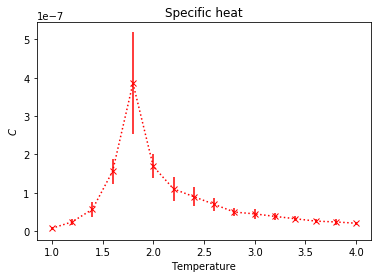

In [13]:
plot_specific_heat(temperature, spec_heat, spec_heat_error)

In [14]:
print(spec_heat)
print(spec_heat_error)

[7.54662839e-09 2.42190738e-08 5.70628772e-08 1.56498368e-07
 3.85903773e-07 1.69084587e-07 1.10218724e-07 9.00170134e-08
 7.00865479e-08 4.98561618e-08 4.51668342e-08 3.85556404e-08
 3.24843246e-08 2.63607131e-08 2.41043394e-08 2.08020985e-08]
[4.20332844e-09 7.04205706e-09 1.93219056e-08 3.25449151e-08
 1.32804653e-07 3.14054388e-08 3.08523433e-08 2.43332034e-08
 1.68513452e-08 9.34510212e-09 1.26166147e-08 9.34567105e-09
 6.93738384e-09 5.48146890e-09 7.30682570e-09 4.29799435e-09]
